<a href="https://colab.research.google.com/github/faaabi93/DGM/blob/master/digitalelevationmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualisierung eines Digitalen Höhenmodells

Auf Basis von ASCII .xyz-Daten


## Imports

In [0]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd
from operator import itemgetter
from itertools import *


# In späterer Version beheben:
pd.options.mode.chained_assignment = None

## Laden der Daten

Die Daten sind zudem frei verfügbar auf der Seite des [Bundesamtes für Kartographie und Geodäsie](https://www.bkg.bund.de/DE/Produkte-und-Services/Shop-und-Downloads/Digitale-Geodaten/Gelaendemodelle/Deutschland/DGM-Deutschland_cont.html). Die Auflösung beträgt einen Kilometer.

In [0]:
colnames = ["X", "Y", "Z"]
# Gespeichert in meinem privaten Repository
data = pd.read_csv("https://raw.githubusercontent.com/faaabi93/DGM/master/dgm1000.utm32s.xyzascii/dgm1000/dgm1000_utm32s.xyz", names = colnames, sep=" ")

## Datentransformation

Um die Daten im letzten Schritt mittels Matplotlib plotten zu können, ist das Ziel im folgenden die Daten zu Normalisieren. Das Ziel ist ein INT-Grid, auf Basis welchen anschließend auch *masked-Arrays* erstellt werden können, so dass die Linien im Graphen an Stellen, an denen keine Daten vorliegen, auch unterbrochen werden.

Zuerst wird demanch der Datensatz allgemein betrachtet und auch die minimalen Werte der Spalten X und Y ermittelt:

In [3]:
print(data.head(3))
print(min(data["X"]))
print(min(data["Y"]))

        X        Y      Z
0  460000  6101000  -1.29
1  461000  6101000  -1.39
2  462000  6101000  13.47
280000
5236000


In [4]:
data["X"] = data["X"] - min(data["X"])
data["Y"] = data["Y"] - min(data["Y"])
print(data.head(3))

        X       Y      Z
0  180000  865000  -1.29
1  181000  865000  -1.39
2  182000  865000  13.47


Die Gitterweite des digitalen Geländemodells beträgt 1000m. Deshalb werden die drei Reihen entsprechend dividiert.

In [0]:
data["X"] = data["X"] / 1000
data["Y"] = data["Y"] / 1000
data["Z"] = data["Z"] / 1000

## Definieren einer Funktion, um Karten zu erzeugen.

Die Funktion nimmt drei Argumente entgegen:  


1.   den DataFrame, aus welchem die Karte erzeugt werden soll
2.   den Modulo-Operator, auf Basis welchem der Dataframe unterteilt wird
3.   den Faktor, mit welchem die Höhe multipliziert wird.
4.   die [Matplotlib-Colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html), welche den Graphen farblich gestaltet.



In [0]:
def draw_lines(df, mod_y, h, clr):
  frame = df.copy()
  colormap = clr
  to_drop = []
  for index, row in data.iterrows():
      if row["Y"] % mod_y != 0:
          to_drop.append(index)
  frame.drop(to_drop, inplace=True)
  y_vals = frame["Y"].unique().tolist()
  fig1 = plt.figure(figsize=(15,15))
  ax1 = fig1.add_subplot(111)
  ax1.set_facecolor('black')
  # für später: Text hinzufügen
  #fig1.text(1, 2, "TEST", bbox=dict(facecolor='red', alpha=0.5))

  for y in y_vals:
      temp_df = frame.loc[frame["Y"] == y]
      temp_df["new_Y"] = temp_df["Y"]
      y = np.array(temp_df["new_Y"].values.tolist())
      x = temp_df["X"].values.tolist()
      z = np.array(temp_df["Z"].values.tolist())
      groups = []
      for k, g in groupby(enumerate(x), lambda x: x[0]-x[1]):
        groups.append(list(map(itemgetter(1), g)))
      my = ma.array(y)
      len_count = 0
      for l in groups[:-1]:
        len_count += len(l)
        my[len_count] = ma.masked
      correct_y = my + h * z
      ax1.plot(x, correct_y)



  #colormap = plt.cm.clr #nipy_spectral, Set1,Paired   
  colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
  for i,j in enumerate(ax1.lines):
      j.set_color(colors[i])
  # Kommentar entfernen, falls außerhalb eines Notebooks benutzt.
  #return fig1

### Beispiele draw_lines

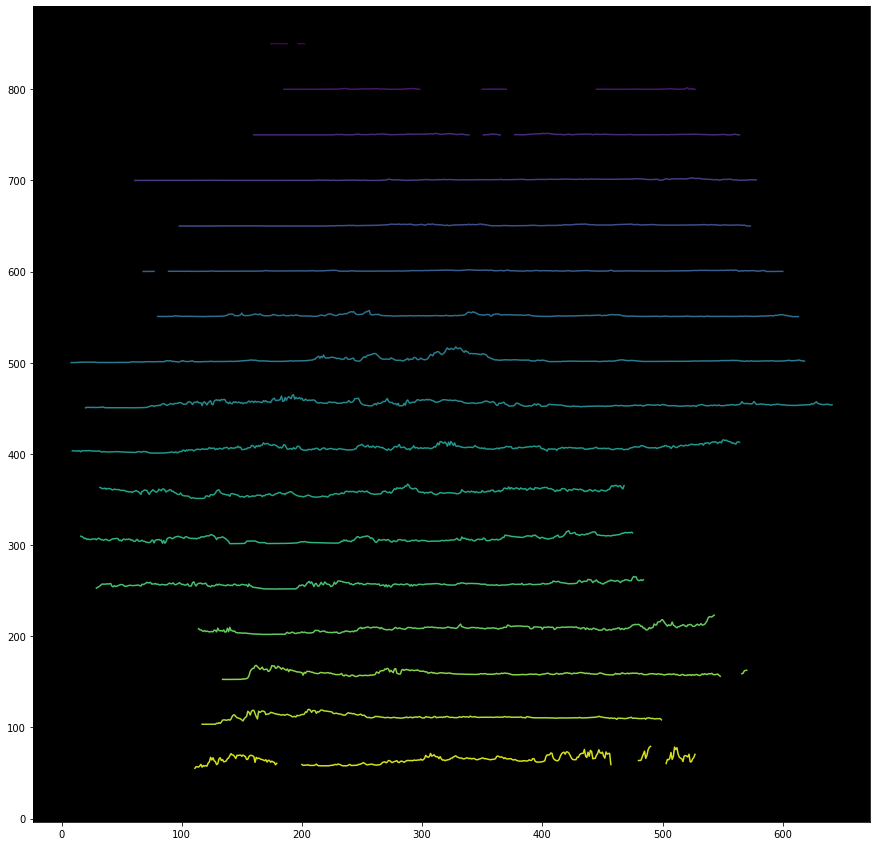

In [7]:
draw_lines(data, 50, 20, plt.cm.viridis)

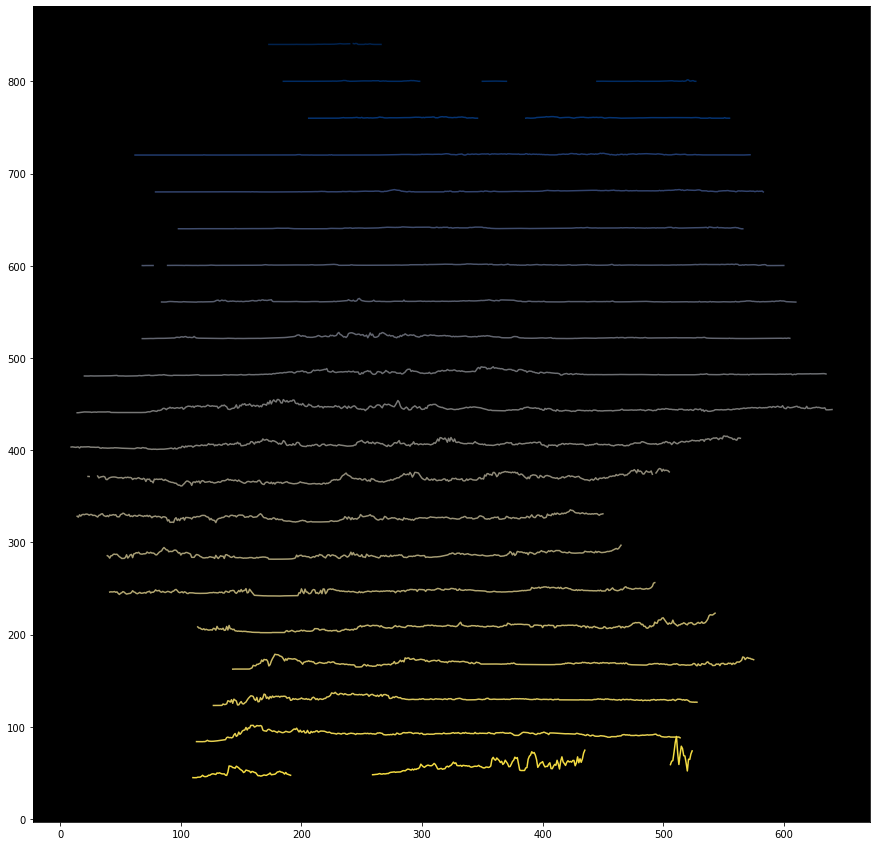

In [8]:
draw_lines(data, 40, 20, plt.cm.cividis)

## Definieren einer neuen Funktion inklusive Gauß-Filter

Im folgenden Abschnitt wird, um die Graphen zu glätten, ein [Gauß-Filter ](https://de.wikipedia.org/wiki/Gau%C3%9F-Filter)verwendet.

In [0]:
from scipy.ndimage.filters import gaussian_filter1d

def draw_lines_gaus(df, mod_y, h, clr):
  frame = df.copy()
  colormap = clr
  to_drop = []
  for index, row in data.iterrows():
      if row["Y"] % mod_y != 0:
          to_drop.append(index)
  frame.drop(to_drop, inplace=True)
  y_vals = frame["Y"].unique().tolist()
  fig1 = plt.figure(figsize=(15,15))
  ax1 = fig1.add_subplot(111)
  ax1.set_facecolor('black')
  # für später: Text hinzufügen
  #fig1.text(1, 2, "TEST", bbox=dict(facecolor='red', alpha=0.5))

  for y in y_vals:
      temp_df = frame.loc[frame["Y"] == y]
      temp_df["new_Y"] = temp_df["Y"]
      y = np.array(temp_df["new_Y"].values.tolist())
      x = temp_df["X"].values.tolist()
      z = np.array(temp_df["Z"].values.tolist())
      groups = []
      for k, g in groupby(enumerate(x), lambda x: x[0]-x[1]):
        groups.append(list(map(itemgetter(1), g)))
      
      correct_y = y + h * z
      correct_y = gaussian_filter1d(correct_y, sigma=3)
      my = ma.array(correct_y)
      len_count = 0
      for l in groups[:-1]:
        len_count += len(l)
        my[len_count] = ma.masked
      ax1.plot(x, my)

  colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
  for i,j in enumerate(ax1.lines):
      j.set_color(colors[i])
  # Kommentar entfernen, falls außerhalb eines Jupyter Notebooks benutzt.
  #return fig1

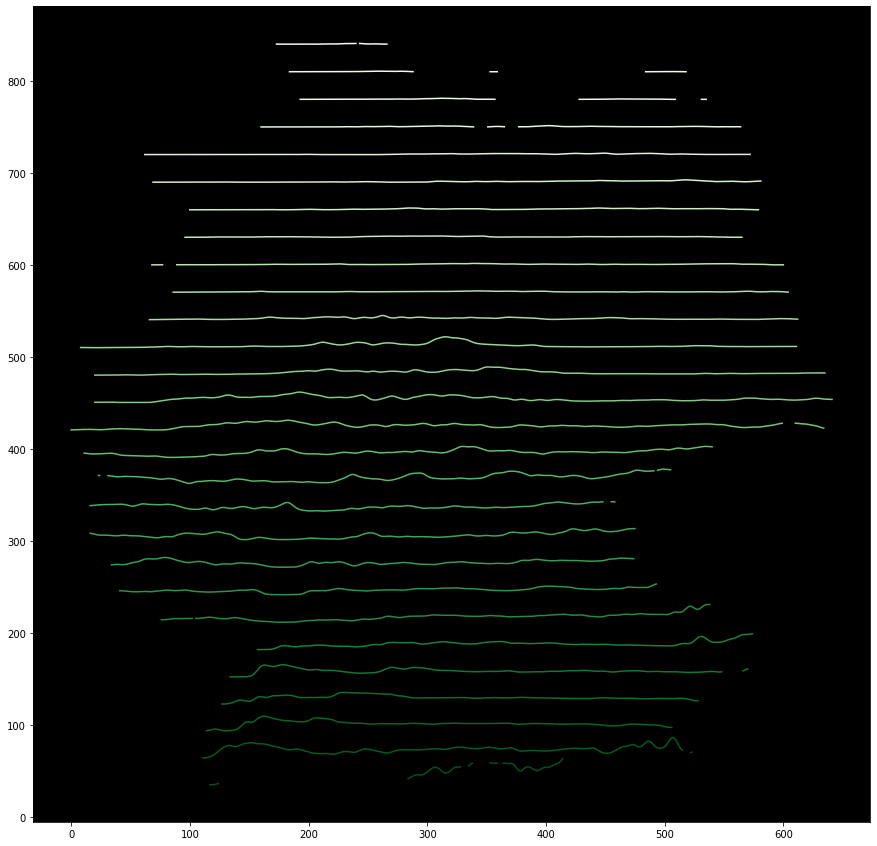

In [10]:
draw_lines_gaus(data, 30, 20, plt.cm.Greens)

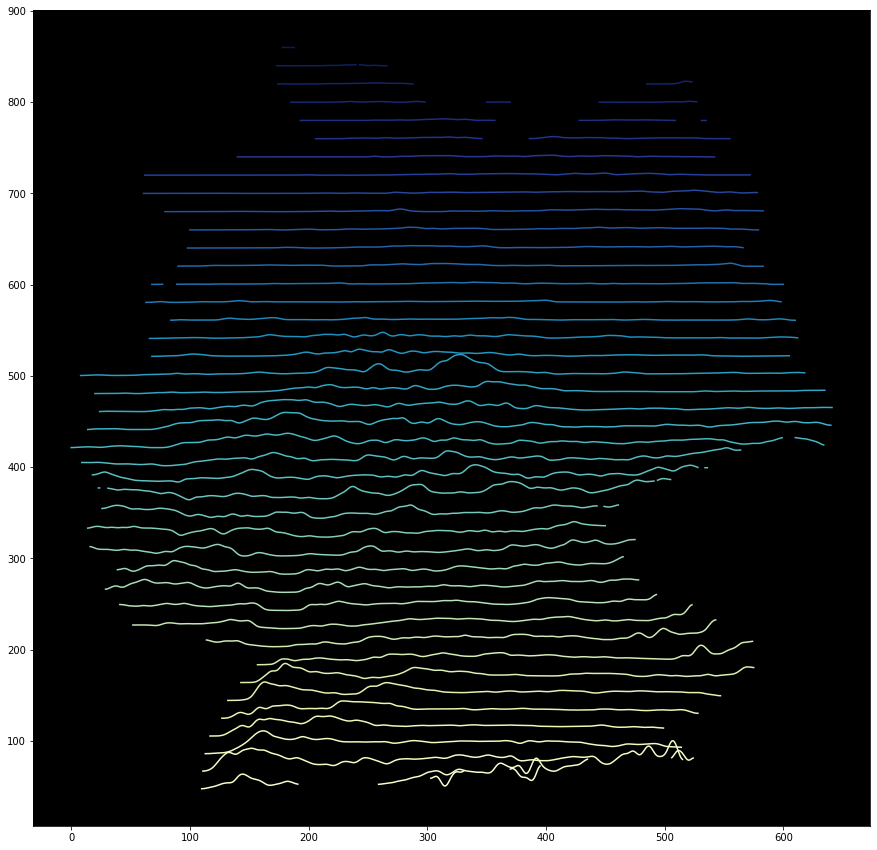

In [11]:
draw_lines_gaus(data, 20, 30, plt.cm.YlGnBu_r)